In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score,precision_recall_fscore_support
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('csv',data_files='dataset_propositionattribution_nerfeatures.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","gem_exp","gem_label","gpt_label","gpt_exp","gold_exp","entity_map_ev","entity_ev","split"],skiprows=1)

Using custom data configuration default-927ab0163adb9fdb
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-927ab0163adb9fdb/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 204.45it/s]


In [3]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-927ab0163adb9fdb/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-d013d5114fa105ab.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-927ab0163adb9fdb/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-16f9acbdd82fea07.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-927ab0163adb9fdb/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-47c7de469e4087a2.arrow


In [4]:
columns_to_keep = ["claim", "premise", "label", "category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 234
    })
})

In [6]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)

# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-927ab0163adb9fdb/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-649518d62ec57bf1.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-927ab0163adb9fdb/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-6d678bc04ef470ab.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-927ab0163adb9fdb/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-43db5994e2921eed.arrow


Label Encoding Mapping: {'contradiction': 2, 'entailment': 0, 'neutral': 1}


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 234
    })
})

In [8]:
labels = np.array(dataset['train']['label'])

In [9]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='sjrhuschlee/flan-t5-base-mnli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts
        claim = item['claim'] 
        evidences = item['premise']
        item['premise']=evidences
        item['claim']=claim
        additional_features = [
            "count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
    
        for feature in additional_features:
            if feature in item:
                claim += "[SEP]" + str(item[feature])
        # Tokenize the texts
        inputs = self.tokenizer(
            evidences,claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
         # Construct the output item
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': evidences  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item



In [10]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [11]:
model_name = "sjrhuschlee/flan-t5-base-mnli"
config = AutoConfig.from_pretrained(
    model_name, num_labels=len(label2id), id2label=id2label, label2id=label2id
)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name,ignore_mismatched_sizes=True,config=config, trust_remote_code=True)
device = "cuda:0"
model.to(device)

Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedGeluDense(
                (wi_0): Linear(in_features=768, out_features=2048, bias=False)
                (wi_1): Line

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(
        logits, tuple
    ):  # if the model also returns hidden_states or attentions
        logits = logits[0]
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted"
    )
    acc = accuracy_score(labels, predictions)


    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [13]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
    num_rows: 1623
})

In [14]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [15]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [16]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [17]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [18]:
tdata.__getitem__(0)

{'input_ids': tensor([   37,  1832, 10229,    13,     3,  6296,  2917,    75,  5167,    11,
            82,    52,    52,   107,   993,     8,  5798,   485,    13,     8,
             3, 19437,  2647, 18270,    16,     8,   123,  1225,   109,    11,
           483,     8,   455,   120,    11, 13809,  1809,    12,   993,     8,
             3, 31970,   485,    13,     8,  1133,    11,  6313,     8, 12515,
          1504,     5,     1,   499,    52,    52,   107,  1832,  1043,    19,
          1664,   261,    16, 26309,   494,    12,   199,  1172,     8,  3179,
            13,     8,  1133,     5,  6306,   134,  8569,   908,   632,  6306,
           134,  8569,   908,   632,  6306,   134,  8569,   908,   632,  6306,
           134,  8569,   908,   632,  6306,   134,  8569,   908,   632,  6306,
           134,  8569,   908,   632,  6306,   134,  8569,   908,   632,  6306,
           134,  8569,   908,   632,  6306,   134,  8569,   908,   632,  6306,
           134,  8569,   908,   632,  6

In [19]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/10.4.3_flant5/',
    num_train_epochs=15,
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=False,
    logging_steps=10,
    warmup_ratio=0.06,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/10.4.3_flant5/best_model')
tokenizer.save_pretrained(f'/home/elson/10.4.3_flant5/best_model')


/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3045


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.621600,0.806743,0.675269,0.697783,0.675269,0.685793
2,0.202500,2.131911,0.593548,0.709982,0.593548,0.632680
3,0.127700,2.305449,0.638710,0.722168,0.638710,0.671757
4,0.277700,2.257205,0.640860,0.697590,0.640860,0.660059
5,0.109100,2.811687,0.640860,0.683135,0.640860,0.654617
6,0.000200,3.183029,0.645161,0.691073,0.645161,0.662603
7,0.000000,3.319775,0.675269,0.698999,0.675269,0.684415
8,0.000100,3.111924,0.662366,0.691910,0.662366,0.674187
9,0.000000,3.474607,0.645161,0.689917,0.645161,0.661756
10,0.000000,3.544796,0.662366,0.684944,0.662366,0.670027


***** Running Evaluation *****
  Num examples = 465
  Batch size = 8
Saving model checkpoint to /home/elson/10.4.3_flant5/checkpoint-203
Configuration saved in /home/elson/10.4.3_flant5/checkpoint-203/config.json
Model weights saved in /home/elson/10.4.3_flant5/checkpoint-203/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 8
Saving model checkpoint to /home/elson/10.4.3_flant5/checkpoint-406
Configuration saved in /home/elson/10.4.3_flant5/checkpoint-406/config.json
Model weights saved in /home/elson/10.4.3_flant5/checkpoint-406/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 8
Saving model checkpoint to /home/elson/10.4.3_flant5/checkpoint-609
Configuration saved in /home/elson/10.4.3_flant5/checkpoint-609/config.json
Model weights saved in /home/elson/10.4.3_flant5/checkpoint-609/pytorch_model.bin
Deleting older checkpoint [/home/elson/10.4.3_flant5/checkpoint-406] due to args.save_total_limit
***** Running Eva

Configuration saved in /home/elson/10.4.3_flant5/best_model/config.json
Model weights saved in /home/elson/10.4.3_flant5/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/10.4.3_flant5/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/10.4.3_flant5/best_model/special_tokens_map.json
Copy vocab file to /home/elson/10.4.3_flant5/best_model/spiece.model


('/home/elson/10.4.3_flant5/best_model/tokenizer_config.json',
 '/home/elson/10.4.3_flant5/best_model/special_tokens_map.json',
 '/home/elson/10.4.3_flant5/best_model/spiece.model',
 '/home/elson/10.4.3_flant5/best_model/added_tokens.json',
 '/home/elson/10.4.3_flant5/best_model/tokenizer.json')

In [20]:
model_path = "/home/elson/10.4.3_flant5/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path,trust_remote_code=True).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/10.4.3_flant5/best_model/config.json
Model config T5Config {
  "_name_or_path": "/home/elson/10.4.3_flant5/best_model/",
  "architectures": [
    "T5ForSequenceClassification"
  ],
  "auto_map": {
    "AutoModelForSequenceClassification": "modeling_t5seq.T5ForSequenceClassification"
  },
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "finetuning_task": "mnli",
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "p

In [21]:
print(test_results)

PredictionOutput(predictions=(array([[ 4.92540956e-01,  3.05404484e-01, -7.58313656e-01],
       [ 2.28307414e+00, -4.57488120e-01, -1.56814194e+00],
       [ 2.46749210e+00, -1.34779215e+00, -8.60033214e-01],
       [-3.68018955e-01, -1.15783334e+00,  1.27487528e+00],
       [-2.39270180e-01,  5.21659493e-01, -3.27760041e-01],
       [ 2.91717744e+00, -6.80669606e-01, -1.70618391e+00],
       [ 2.39236927e+00, -1.08713520e+00, -9.65193689e-01],
       [ 2.54804921e+00, -1.76529467e-01, -1.99456453e+00],
       [ 1.19203711e+00, -1.30807161e-01, -1.01542616e+00],
       [ 2.11511445e+00, -7.75320351e-01, -1.06411576e+00],
       [ 1.66960728e+00, -1.75781083e+00,  2.90267766e-01],
       [ 2.28002286e+00, -5.48987329e-01, -1.37001705e+00],
       [ 1.93361914e+00, -2.00123832e-01, -1.48141694e+00],
       [ 2.35907841e+00,  7.53045008e-02, -2.12024927e+00],
       [ 2.43031502e+00, -5.11330724e-01, -1.56197000e+00],
       [ 8.65169406e-01,  2.04451695e-01, -9.12322402e-01],
       [ 1

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
predictions_array = np.array(test_results.predictions[0])

predictions_tensor = torch.tensor(predictions_array).to(torch.float32)
probabilities = torch.softmax(predictions_tensor, dim=-1)

predictions = np.argmax(probabilities.numpy(), axis=1)

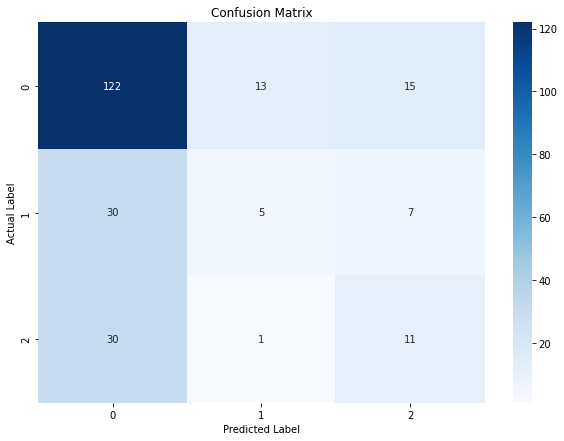

In [24]:
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Adjust xticklabels and yticklabels as needed
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


In [25]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/10.4.3_results.csv', index=False)

In [26]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [27]:
correct_classification_counts

General Health           34
Bone health              16
Cancer                   12
Fitness                   9
Throat                    9
Neurological health       8
Cardiovascular Health     7
Diabetes                  7
Skin                      7
Hair                      6
Ear                       6
COVID                     4
Women' s Health           3
Mental Health             3
Blood                     3
Muscles                   2
Men's health              1
Eye                       1
Name: Category, dtype: int64

In [28]:
misclassification_counts

General Health           17
Skin                     17
Eye                       8
Blood                     6
Fitness                   6
Hair                      6
Diabetes                  5
Men's health              5
Cardiovascular Health     5
Bone health               5
Muscles                   4
Women' s Health           3
Vascular                  3
Dental Health             3
COVID                     2
Neurological health       1
Name: Category, dtype: int64